In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

import celltrip


# Styling
mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(context='paper', style='dark', palette='colorblind')

# Read data and initialize manager

In [3]:
# Read data
adatas = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/dyngen/logcounts.h5ad',
    's3://nkalafut-celltrip/dyngen/counts_protein.h5ad',
    backed=True)

# Load manager
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Dyngen-251015', 800
manager = celltrip.manager.BasicManager(
    policy_fname=f'{prefix}-{training_step:04}.weights',
    preprocessing_fname=f'{prefix}.pre',
    mask_fname=f'{prefix}.mask',
    adatas=adatas,
    device='cuda')

# Get imputed/recovered modalities

In [4]:
# Simulate to steady state
manager.reset_env()
manager.simulate()
manager.save_state('steady')
gex, protein = manager.get_state()

100%|██████████| 5120/5120 [00:47<00:00, 106.78it/s]


## Visualize

/home/ubuntu/miniconda3/envs/celltrip/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


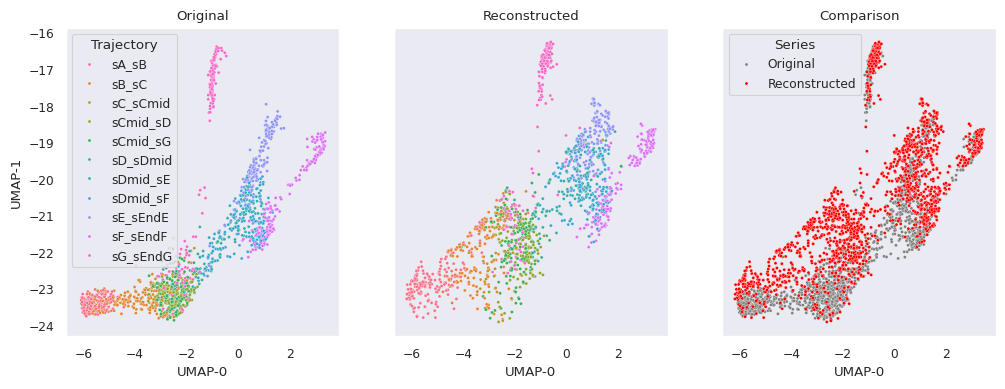

In [5]:
# Reduce
reducer = umap.UMAP(n_components=2, n_neighbors=200, random_state=42)
embed = reducer.fit_transform(np.concat([np.array(adatas[0].X[:].todense()), gex], axis=0))
embed_orig = embed[:adatas[0].shape[0]]
embed_recon = embed[adatas[0].shape[0]:]

# Format
df_orig = pd.DataFrame(embed_orig, index=adatas[0].obs_names, columns=['UMAP-0', 'UMAP-1'])
df_orig['Series'] = 'Original'
df_recon = pd.DataFrame(embed_recon, index=adatas[0].obs_names, columns=['UMAP-0', 'UMAP-1'])
df_recon['Series'] = 'Reconstructed'
df = pd.concat([df_orig, df_recon], axis=0)
df['Trajectory'] = adatas[0].obs.loc[df.index, 'traj_sim']
# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
sns.scatterplot(
    df.loc[df['Series']=='Original'].drop(columns='Series'),
    x='UMAP-0', y='UMAP-1', hue='Trajectory', s=5, ax=axs[0])
axs[0].set_title('Original')
sns.scatterplot(
    df.loc[df['Series']=='Reconstructed'].drop(columns='Series'),
    x='UMAP-0', y='UMAP-1', hue='Trajectory', s=5, legend=False,
    ax=axs[1])
axs[1].set_title('Reconstructed')
sns.scatterplot(
    df.drop(columns='Trajectory'),
    x='UMAP-0', y='UMAP-1', hue='Series', s=5, palette=['gray', 'red'],
    ax=axs[2])
axs[2].set_title('Comparison');


# Gene knockdown

In [6]:
# Simulate perturbation
manager.add_perturbation(
    ['C8_TF1', 'C8_TF2', 'C8_TF3', 'C8_TF4', 'C8_TF5'],
    modality=0, feature_targets=0)
# manager.add_perturbation(
#     ['C8_TF1', 'C8_TF2', 'C8_TF3', 'C8_TF4', 'C8_TF5'],
#     modality=1, feature_targets=0)
time, states = manager.simulate_perturbation()

# Revert to previous state for next perturbation
manager.load_state('steady')
manager.clear_perturbations()

100%|██████████| 1280/1280 [00:07<00:00, 174.61it/s]


## Visualize

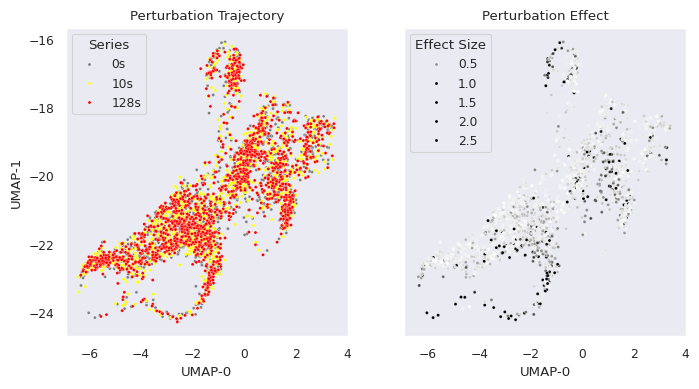

In [7]:
# Reduce
embed_start = reducer.transform(states[0][0])
embed_inter = reducer.transform(states[0][1])
embed_end = reducer.transform(states[0][-1])

# Format
df_start = pd.DataFrame(embed_start, index=adatas[0].obs_names, columns=['UMAP-0', 'UMAP-1'])
df_start['Series'] = '0s'
df_inter = pd.DataFrame(embed_inter, index=adatas[0].obs_names, columns=['UMAP-0', 'UMAP-1'])
df_inter['Series'] = '10s'
df_end = pd.DataFrame(embed_end, index=adatas[0].obs_names, columns=['UMAP-0', 'UMAP-1'])
df_end['Series'] = '128s'
df = pd.concat([df_start, df_inter, df_end], axis=0)
df_effect = pd.DataFrame(embed_start, index=adatas[0].obs_names, columns=['UMAP-0', 'UMAP-1'])
df_effect['Effect Size'] = np.sqrt(np.square(embed_end - embed_start).sum(keepdims=True, axis=1))
# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.scatterplot(
    df, x='UMAP-0', y='UMAP-1', hue='Series', s=5,
    palette=['gray', 'yellow', 'red'], ax=axs[0])
axs[0].set_title('Perturbation Trajectory')
sns.scatterplot(
    df_effect, x='UMAP-0', y='UMAP-1', hue='Effect Size',
    palette='Grays', hue_norm=(0, 1), s=5, ax=axs[1])
axs[1].set_title('Perturbation Effect');


# Developmental stage recovery

In [8]:
# Get origin and terminal data
origin_samples = adatas[0].obs.index[adatas[0].obs['traj_sim'] == 'sC_sCmid']
terminal_samples = adatas[0].obs.index[adatas[0].obs['traj_sim'] == 'sE_sEndE']
origin_modalities = [np.array(ad[origin_samples].X[:].todense()) for ad in adatas]
terminal_modalities = [np.array(ad[terminal_samples].X[:].todense()) for ad in adatas]

# Generate pseudocells
origin_pcells, terminal_pcells = celltrip.utility.processing.generate_pseudocells(
    origin_modalities,
    terminal_modalities,
    kmeans_modality=0,  # Which modality to use when determining clusters
    ot_modality=0,  # Which modality to use when determining pseudocell correspondence
    n_pcells=None)  # OPTIONAL. Manually set number of pseudocells

# Format into adatas
origin_pcells = [ad.AnnData(m, var=adatas[0].var) for m in origin_pcells]
terminal_pcells = [ad.AnnData(m, var=adatas[0].var) for m in terminal_pcells]

In [9]:
# Change environment modalities and reset
manager.set_modalities(origin_pcells)
manager.reset_env()

# Simulate to steady state
manager.simulate();

100%|██████████| 5120/5120 [00:14<00:00, 362.39it/s]


In [10]:
# Replace cell/pseudocell modalities with terminal modalities
manager.set_modalities(terminal_pcells)

# Simulate
time, states = manager.simulate(
    time=32.,  # Simulate for 32 seconds (Default 512s)
    skip_time=1.)  # Record state every second (Default 10s)

# Manually select intermediate timepoint as recovered stage
intermediate_pcells = [s[5] for s in states]  # Modalities at 5s

100%|██████████| 320/320 [00:00<00:00, 359.39it/s]


## Visualize

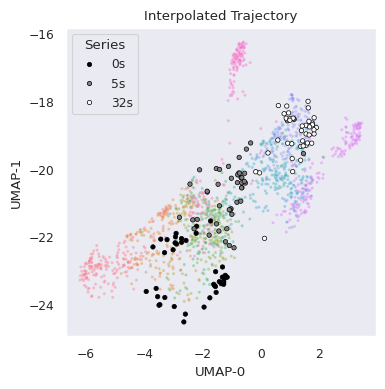

In [11]:
# Reduce
embed_start = reducer.transform(origin_pcells[0].X)
embed_inter = reducer.transform(intermediate_pcells[0])
embed_end = reducer.transform(terminal_pcells[0].X)

# Format
df_recon = pd.DataFrame(embed_recon, index=adatas[0].obs_names, columns=['UMAP-0', 'UMAP-1'])
df_recon['Trajectory'] = adatas[0].obs['traj_sim']
df_start = pd.DataFrame(embed_start, columns=['UMAP-0', 'UMAP-1'])
df_start['Series'] = '0s'
df_inter = pd.DataFrame(embed_inter, columns=['UMAP-0', 'UMAP-1'])
df_inter['Series'] = '5s'
df_end = pd.DataFrame(embed_end, columns=['UMAP-0', 'UMAP-1'])
df_end['Series'] = '32s'
df = pd.concat([df_start, df_inter, df_end], axis=0)
df_effect = pd.DataFrame(embed_start, columns=['UMAP-0', 'UMAP-1'])
df_effect['Effect Size'] = np.sqrt(np.square(embed_end - embed_start).sum(keepdims=True, axis=1))
# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)
sns.scatterplot(
    df_recon, x='UMAP-0', y='UMAP-1', hue='Trajectory', s=5,
    alpha=.4, legend=False, ax=ax)
sns.scatterplot(
    df, x='UMAP-0', y='UMAP-1', hue='Series', s=10, lw=.5,
    palette=[3*[i] for i in (0, .5, 1.)], edgecolor='black',
    ax=ax)
ax.set_title('Interpolated Trajectory');
